In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, RandomizedSearchCV,cross_val_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error, r2_score
# import tensorflow as tf
# from tensorflow.keras import layers, regularizers, callbacks
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
import warnings 
warnings.filterwarnings("ignore")

In [2]:
raw_df = pd.read_csv("../Output/Data/processed_data.csv")
raw_df.head(1)
raw_df['Price'] = raw_df['Price'] / 25500 # chuyển sang đô la
raw_df = raw_df.drop(columns=['CPU Name','GPU Name','Storage Type'])
raw_df = raw_df.sample(frac=1,random_state=42).reset_index(drop=True)

In [3]:
def grid_search_polynomial(pow : float = 2,cross_val : bool = True,random_state : int = 42):
    cols = raw_df.columns
    result = {}
    def inner_grid_search(df_):
        X_ = df_.drop('Price', axis=1)
        y_ = df_['Price']
        X_train, X_test, y_train, y_test = train_test_split(X_, y_, test_size=0.2, random_state=random_state)
        model = LinearRegression()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test,y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        inner_result = [r2,mae,mse]
        return inner_result
    def inner_grid_search_cross_val(df_):
        X_ = df_.drop('Price', axis=1)
        y_ = df_['Price']
        model = LinearRegression()
        mse = -cross_val_score(model,X_,y_,cv=5,scoring='neg_mean_squared_error').mean()
        r2 = cross_val_score(model,X_,y_,cv=5,scoring='r2').mean()
        mae = -cross_val_score(model,X_,y_,cv=5,scoring='neg_mean_absolute_error').mean()
        inner_result = [r2,mae,mse]
        return inner_result
    for col in cols:
        df = raw_df.copy()
        df[col+' S'] = df[col] ** pow
        if (cross_val == True):
            result[col] = inner_grid_search_cross_val(df)
        else:
            result[col] = inner_grid_search(df)
    result['Base'] = inner_grid_search_cross_val(raw_df.copy())
    return result

In [4]:
def grid_search_product(cross_val : bool = True,random_sate : int = 42):
    cols = raw_df.columns
    result = {}
    def inner_grid_search(df_):
        X_ = df_.drop('Price', axis=1)
        y_ = df_['Price']
        X_train, X_test, y_train, y_test = train_test_split(X_, y_, test_size=0.2, random_state=random_sate)
        model = LinearRegression()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test,y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        inner_result = [r2,mae,mse]
        return inner_result
    def inner_grid_search_cross_val(df_):
        X_ = df_.drop('Price', axis=1)
        y_ = df_['Price']
        model = LinearRegression()
        mse = -cross_val_score(model,X_,y_,cv=5,scoring='neg_mean_squared_error').mean()
        r2 = cross_val_score(model,X_,y_,cv=5,scoring='r2').mean()
        mae = -cross_val_score(model,X_,y_,cv=5,scoring='neg_mean_absolute_error').mean()
        inner_result = [r2,mae,mse]
        return inner_result
    for i in range(len(cols)):
        for j in range(i+1,len(cols)):
            df = raw_df.copy()
            df['Product Column'] = df[cols[i]] * df[cols[j]]
            if (cross_val == True):
                result[cols[i] + '|' + cols[j]] = inner_grid_search_cross_val(df)
            else:
                result[cols[i] + '|' + cols[j]] = inner_grid_search(df)
    result['Base'] = inner_grid_search_cross_val(raw_df.copy())
    return result

In [5]:
def format_result(result_ : dict):
    base = result_['Base']
    for key in result_:
        if (key != 'Base'):
            for i in range(len(result_[key])):
                result_[key][i] -= base[i]
def sorted_print(result_ : dict):
    local_result = result_.copy()
    while(len(local_result) > 0):
        max = -1
        max_key = None
        for key in local_result:
            if (local_result[key][0] > max):
                max = local_result[key][0]
                max_key = key
        print(local_result[max_key],max_key)
        local_result.pop(max_key)


In [22]:
result = grid_search_product(cross_val=False)
format_result(result)
sorted_print(result)
# for col in result:
#     print(result[col],col)

[0.7566129310459174, 303.709032520028, 198098.7769300718] Base
[0.2429565026013707, -289.83507741132337, -197714.63834646792] Price|OS
[0.24173282426538267, -282.46049016202863, -196622.908675042] Price|Max DDR Support
[0.24081479155103924, -271.1918332793614, -195803.86700035294] Price|Memory Type
[0.24033494903969876, -265.7385583998577, -195375.7656833357] Price|CPU Max Clock
[0.2218362211665098, -211.31799532304325, -178871.7470136848] Price|CPU Achitecture
[0.21805595501196107, -198.29476369300988, -175499.10519644147] Price|Display Size
[0.2083008960058812, -176.55652305191217, -166795.92965574766] Price|Display Width
[0.20506595375114056, -171.03582803388616, -163909.80971639435] Price|Display Height
[0.1953074701996278, -154.527116335736, -155203.57889740533] Price|CPU Thread
[0.19520506094480727, -154.87505130093984, -155112.2123847949] Price|CPU Cache
[0.18426950660714536, -146.94514283310565, -145355.83377384546] Price|Base Power
[0.1828699918631671, -137.40030242691736, -14

In [47]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 906 entries, 0 to 905
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Price              906 non-null    float64
 1   CPU Achitecture    906 non-null    int64  
 2   CPU Core           906 non-null    float64
 3   CPU Thread         906 non-null    float64
 4   CPU Cache          906 non-null    int64  
 5   CPU Base Clock     906 non-null    float64
 6   CPU Max Clock      906 non-null    float64
 7   CPU Intel          906 non-null    int64  
 8   Base Power         906 non-null    int64  
 9   Max Power          906 non-null    int64  
 10  RAM                906 non-null    int64  
 11  Memory Type        906 non-null    int64  
 12  Max DDR Support    906 non-null    float64
 13  Storage            906 non-null    int64  
 14  GPU VRAM           906 non-null    float64
 15  GPU Onboard        906 non-null    int64  
 16  GPU AMD            906 non

In [48]:
correlation_matrix = raw_df.corr()
# print(correlation_matrix)

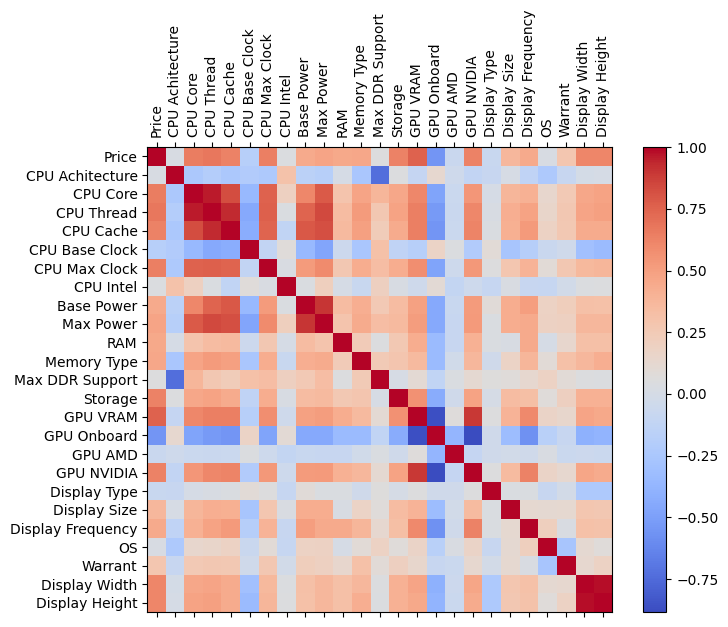

In [49]:
# Plot the correlation matrix
plt.figure(figsize=(8, 6))
plt.matshow(correlation_matrix, cmap='coolwarm', fignum=1)
plt.colorbar()

# Set axis labels
plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=90)
plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)

# Show plot
plt.show()

In [8]:
df = raw_df.copy()
# df['Display Resolution'] = raw_df['Display Height'] * raw_df['Display Width']
# df['Display Ratio'] = raw_df['Display Size'] / raw_df['Display Resolution']
# df = df.drop(columns=['Display Height','Display Width'])
df['GPU VRAM 2'] = df['GPU VRAM']**2
df['Warrant 2'] = df['Warrant']**2
# df['Display Width 2'] = df['Display Width']**2
# df['Display Height 2'] = df['Display Height']**2
# df['Display Size'] = 1/df['Display Size']
df['Product 1'] = df['RAM'] * df['Display Size']
df['Product 2'] = df['RAM'] * df['GPU VRAM']
# df['Product 3'] = df['RAM'] * df['CPU Thread']
# df['Product 4'] = df['RAM'] * df['CPU Core']
# df['Product 5'] = df['RAM'] * df['CPU Cache']
# df['Product 6'] = df['RAM'] * df['CPU Base Clock']
# df['Product 7'] = df['RAM'] * df['CPU Max Clock']
# df['Product 8'] = df['RAM'] * df['Base Power']
# df['Product 9'] = df['RAM'] * df['Max Power']
# df['Storage Ratio'] = df['Storage'] / df['RAM']
# df['CPU Effecient'] = df['Base Power'] / df['CPU Core']
# df['CPU Max Effecient'] = df['Base Power'] / df['CPU Core']
# df['Display Frequency'] = df['Display Frequency']**2
# df = df.drop(columns=['Display Size'])

In [94]:
df = raw_df.copy()

In [118]:
X = df.drop('Price', axis=1)
y = df['Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print(f'Mean squared error: {mse}')

r2 = r2_score(y_test,y_pred)
print(f'R2 Score: {r2}')

mae = mean_absolute_error(y_test, y_pred)
print(f'Mean absolute error: {mae}')

Mean squared error: 156437.58628842435
R2 Score: 0.8041972700735139
Mean absolute error: 282.7861652018917


In [10]:
model = LinearRegression()
mse = -cross_val_score(model,X,y,cv=5,scoring='neg_mean_squared_error').mean()
r2 = cross_val_score(model,X,y,cv=5,scoring='r2').mean()
mae = -cross_val_score(model,X,y,cv=5,scoring='neg_mean_absolute_error').mean()
print(f'Mean squared error: {mse}')
print(f'R2 Score: {r2}')
print(f'Mean absolute error: {mae}')

Mean squared error: 156656.6783464923
R2 Score: 0.8140092257635718
Mean absolute error: 275.0455308447912


# Model Selection, Training, Evaluation

In [61]:
X = df.drop('Price', axis=1)
y = df['Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

In [62]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print(f'Mean squared error: {mse}')

r2 = r2_score(y_test,y_pred)
print(f'R2 Score: {r2}')

mae = mean_absolute_error(y_test, y_pred)
print(f'Mean absolute error: {mae}')

Mean squared error: 241971.2062595111
R2 Score: 0.7563936806737234
Mean absolute error: 345.4364382668299


In [63]:
def grid_search_single_axis(from_ : float,to_ : float,step : float,model,set_func : callable,
                            X_train_,X_test_,y_train_,y_test_,result = None):
    if (result == None):
        result = []
    set_func(model,from_)
    if (from_ > to_):
        return result
    model.fit(X_train_,y_train_)
    y_pred_ = model.predict(X_test_)
    r2_ =  r2_score(y_test_,y_pred_)
    result.append([from_,r2_])
    from_ += step
    return grid_search_single_axis(from_,to_,step,model,set_func,X_train_,X_test_,y_train_,y_test_,result)
    

In [66]:
para = 1
lasso = Ridge(alpha=para)
def set_function(model,alpha):
    model.alpha = alpha
result = grid_search_single_axis(0,1,0.01,lasso,set_function,X_train,X_test,y_train,y_test)
for step in result:
    print('R2 : {} , Alpha : {}'.format(step[1],step[0]))

R2 : 0.7563936806737228 , Alpha : 0
R2 : 0.7563934852962308 , Alpha : 0.01
R2 : 0.75639328624009 , Alpha : 0.02
R2 : 0.7563930835133955 , Alpha : 0.03
R2 : 0.756392877124223 , Alpha : 0.04
R2 : 0.7563926670806317 , Alpha : 0.05
R2 : 0.7563924533906611 , Alpha : 0.060000000000000005
R2 : 0.7563922360623351 , Alpha : 0.07
R2 : 0.7563920151036568 , Alpha : 0.08
R2 : 0.7563917905226135 , Alpha : 0.09
R2 : 0.7563915623271737 , Alpha : 0.09999999999999999
R2 : 0.7563913305252885 , Alpha : 0.10999999999999999
R2 : 0.7563910951248913 , Alpha : 0.11999999999999998
R2 : 0.7563908561338961 , Alpha : 0.12999999999999998
R2 : 0.7563906135602023 , Alpha : 0.13999999999999999
R2 : 0.75639036741169 , Alpha : 0.15
R2 : 0.7563901176962208 , Alpha : 0.16
R2 : 0.7563898644216397 , Alpha : 0.17
R2 : 0.7563896075957752 , Alpha : 0.18000000000000002
R2 : 0.7563893472264366 , Alpha : 0.19000000000000003
R2 : 0.756389083321416 , Alpha : 0.20000000000000004
R2 : 0.7563888158884888 , Alpha : 0.21000000000000005


In [67]:
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)
para = 1
# Lasso Regression (L1 regularization)
lasso = Lasso(alpha=para)  # Alpha is the regularization parameter (lambda)
lasso.fit(X_train, y_train)
lasso_pred = lasso.predict(X_test)
lasso_mse = mean_squared_error(y_test, lasso_pred)
lasso_r2 = r2_score(y_test,lasso_pred)
print("Lasso MSE:", lasso_mse)
print("Lasso R2:", lasso_r2)

# Ridge Regression (L2 regularization)
ridge = Ridge(alpha=para)  # Alpha is the regularization parameter (lambda)
ridge.fit(X_train, y_train)
ridge_pred = ridge.predict(X_test)
ridge_mse = mean_squared_error(y_test, ridge_pred)
ridge_r2 = r2_score(y_test,ridge_pred)
print("Ridge MSE:", ridge_mse)
print("Ridge R2:", ridge_r2)

Lasso MSE: 242162.4430725622
Lasso R2: 0.7562011515837246
Ridge MSE: 242007.4671997922
Ridge R2: 0.7563571747012412


In [68]:
forest = RandomForestRegressor()
forest.fit(X_train, y_train)

forest.score(X_test, y_test)

0.814142546549371

In [69]:
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(random_state=45, max_samples=0.22),
    'Support Vector Machine': SVR(),
    'K-Nearest Neighbors': KNeighborsRegressor(),
    'Gradient Boosting': GradientBoostingRegressor(),
    'AdaBoost': AdaBoostRegressor(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'ElasticNet Regression': ElasticNet(),
    'XGBoost': xgb.XGBRegressor(),
    'LightGBM': lgb.LGBMRegressor(),
    'CatBoost': cb.CatBoostRegressor(silent=True)
}

# Train and evaluate each model
for name, model in models.items():
    model.fit(X_train, y_train)
    
    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Calculate mean absolute error scores
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    r2 = r2_score(y_test,y_test_pred)
    
    # Print the name of the model and its mean absolute error scores
    print(f'{name}: Train MAE = {train_mae}') 
    print(f'{name}: Test MAE = {test_mae}')
    print(f'{name}: R2 = {r2}')
    print('***********************')

Linear Regression: Train MAE = 289.37628930283216
Linear Regression: Test MAE = 345.4364382668299
Linear Regression: R2 = 0.7563936806737234
***********************
Decision Tree: Train MAE = 14.026022563721622
Decision Tree: Test MAE = 254.27242178922853
Decision Tree: R2 = 0.75445784830316
***********************
Random Forest: Train MAE = 177.80545733449915
Random Forest: Test MAE = 262.3355048429628
Random Forest: R2 = 0.795403850400094
***********************
Support Vector Machine: Train MAE = 540.8342504474915
Support Vector Machine: Test MAE = 608.9607708594654
Support Vector Machine: R2 = -0.1258205721506147
***********************
K-Nearest Neighbors: Train MAE = 232.18606868161626
K-Nearest Neighbors: Test MAE = 302.78702865761693
K-Nearest Neighbors: R2 = 0.7264026093667003
***********************
Gradient Boosting: Train MAE = 151.4499057907936
Gradient Boosting: Test MAE = 257.31739639106087
Gradient Boosting: R2 = 0.8147253129572388
***********************
AdaBoost: Trai